In [1]:
import gpytorch

from bo_functions import best_error_advanced
from bo_functions import calc_ei_advanced
from bo_functions import LHS_Design
from bo_functions import create_y_data
from bo_functions import test_train_split
from bo_functions import ExactGPModel
from bo_functions import train_GP_model
from bo_functions import calc_GP_outputs
from bo_functions import calc_y_expected
from bo_functions import improvement

from bo_plotters import plotter_adv
from bo_plotters import y_plotter_adv
from bo_plotters import stdev_plotter_adv
from bo_plotters import ei_plotter_adv
from bo_plotters import improvement_plot

In [2]:
#Set noise parameters and load csv file to generate training data
noise_std = 0.1**2
all_p = LHS_Design("LHS_Toy_3_Input.csv")
all_y = create_y_data(all_p, noise_std)

#Separate training and testing data, uses default of an 80%/20% split
train_test_data = test_train_split(all_p,all_y)

train_p = train_test_data[0] #1x19
train_y = train_test_data[1] #1x19
test_p = train_test_data[2] #1x19
test_y = train_test_data[3] #1x19

In [3]:
# initialize likelihood and model
##Assumes a homoskedastic noise model p(y | f) = f + noise
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# We will use the simplest form of GP model, exact inference
#Defines our model in terms of the class parameters in bo_functions
model = ExactGPModel(train_p, train_y, likelihood)

In [4]:
#Set number of training iterations and train GP
iterations = 500
train_GP_model(model,likelihood, train_p, train_y, iterations)

In [5]:
# Get into evaluation (predictive posterior) mode
#Puts model in evaluation mode
model.eval()
#Puts likelihood in evaluation mode
likelihood.eval();

In [6]:
#Calculates GP outputs for mean, variance, standard devaition, and y output
GP_Outputs = calc_GP_outputs(model,likelihood,test_p)

model_mean = GP_Outputs[0] #1x6
model_variance= GP_Outputs[1] #1x6
model_stdev = GP_Outputs[2] #1x6
model_y = GP_Outputs[3] #1x6

#Calculates expected y
y_exp = calc_y_expected(test_p, noise_std) #1x6

print("Model Mean \n", model_mean)
print("Model Variance \n", model_variance)
print("Model y \n", model_y)
print("Y Value Expected \n", y_exp)

In [7]:
#Calculates best_error and expected improvement
best_error = best_error_advanced(model_y, y_exp)[0] #Scaler
best_x = best_error_advanced(model_y, y_exp)[1] #1x3
ei = calc_ei_advanced(best_error,model_mean,model_variance, y_exp) #1x6
print("EI:",ei)

Upper bound is 2.6154661168300732
Lower bound is -1.5778651122987086
pdf upper is 0.013046047856213853
cdf upper is 0.9955447119161712
pdf lower is 0.11489142931028441
cdf lower is 0.05729830069351265
EI: [-47.90291014  -1.25225279  -5.28136836 -16.12145505  -5.94343913
  -4.51061867]


In [8]:
Integrand_values = improvement(best_error,model_mean,model_variance,y_exp)
print("Lower Improvement Integrand is \n",Integrand_values[0] )
print("Upper Improvement Integrand is \n",Integrand_values[1] )

Lower Improvement Integrand is 
 [-13.76283248  -1.73468994  -3.9362929    0.          -3.928071
  -3.40139257]
Upper Improvement Integrand is 
 [ 0.         -0.62721665 -0.31656601 -1.75913457 -0.24795953 -0.2792188 ]


(array([-13.76283248,  -1.73468994,  -3.9362929 ,   0.        ,
        -3.928071  ,  -3.40139257]), array([ 0.        , -0.62721665, -0.31656601, -1.75913457, -0.24795953,
       -0.2792188 ]))
Improvement is (array([-13.76283248,  -1.73468994,  -3.9362929 ,   0.        ,
        -3.928071  ,  -3.40139257]), array([ 0.        , -0.62721665, -0.31656601, -1.75913457, -0.24795953,
       -0.2792188 ]))


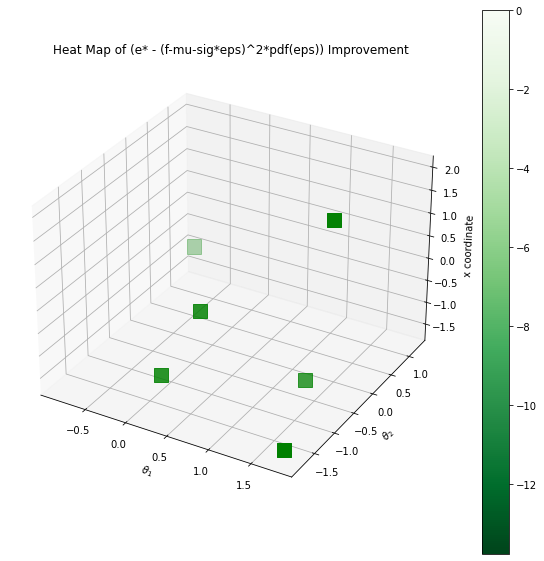

None


In [9]:
I = improvement(best_error,model_mean,model_variance,y_exp)
print(I)
print("Improvement is", I)
print(improvement_plot(test_p,I))

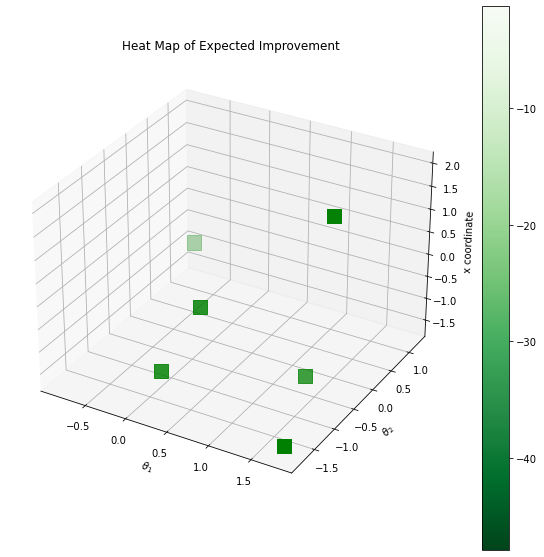

None


In [10]:
print(ei_plotter_adv(test_p, ei))

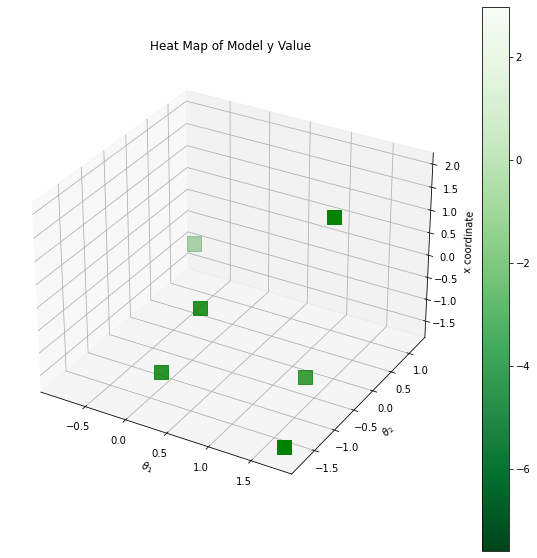

None


In [11]:
y_title = "Model y Value"
print(y_plotter_adv(test_p, model_y, y_title))

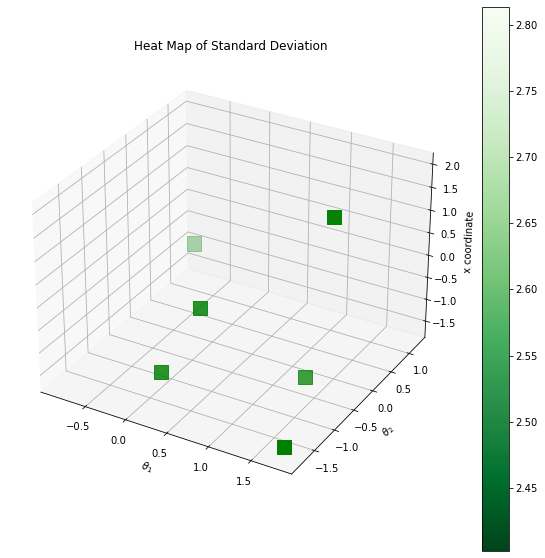

None


In [12]:
print(stdev_plotter_adv(test_p, model_stdev))